In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
'''
https://archive.ics.uci.edu/ml/datasets/Online+Retail
'''
df = pd.read_csv('orders.csv')

In [3]:
df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [4]:
df.head()
aggr_df = df.groupby('order_hour_of_day')[['order_id']].count()
aggr_df.columns = ['freq']
aggr_df['hour'] = aggr_df.index

In [5]:
aggr_df.head()

,freq,hour
order_hour_of_day,,
0,22758,0
1,12398,1
2,7539,2
3,5474,3
4,5527,4


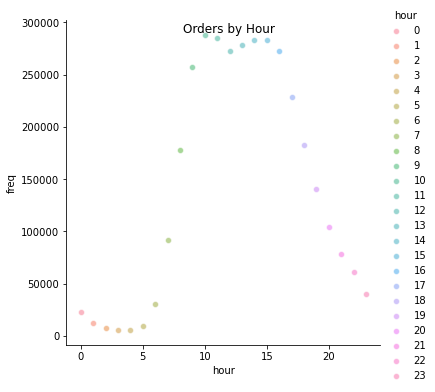

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(aggr_df.dropna(),
             hue='hour',
             x_vars=['hour'],
             y_vars='freq',
             height=5,
             plot_kws={'alpha':0.5, 'linewidth':1}
            )
plt.suptitle('Orders by Hour')
plt.show()

In [7]:
def modify(x):
    if x < 10:
        return '2022-01-01 0' + str(x) +':00:00'
    return '2022-01-01 ' + str(x) +':00:00'
aggr_df['hour'] = aggr_df['hour'].apply(modify)


In [8]:
aggr_df = aggr_df.reset_index().rename(columns={'hour':'ds', 'freq':'y'})
aggr_df.tail(n=3)
aggr_df2 = aggr_df.copy()
aggr_df2['ds'] = pd.DatetimeIndex(aggr_df2['ds'])

In [9]:
frames = []
for i in range(0, 90):
    tmp = aggr_df.copy()
    tmp['ds'] = pd.DatetimeIndex(tmp['ds']) + pd.DateOffset(i)
    frames.append(tmp)
aggr_df = pd.concat(frames)
aggr_df

,order_hour_of_day,y,ds
0,0,22758,2022-01-01 00:00:00
1,1,12398,2022-01-01 01:00:00
2,2,7539,2022-01-01 02:00:00
3,3,5474,2022-01-01 03:00:00
4,4,5527,2022-01-01 04:00:00
...,...,...,...
19,19,140569,2022-03-31 19:00:00
20,20,104292,2022-03-31 20:00:00
21,21,78109,2022-03-31 21:00:00
22,22,61468,2022-03-31 22:00:00


INFO:numexpr.utils:NumExpr defaulting to 6 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


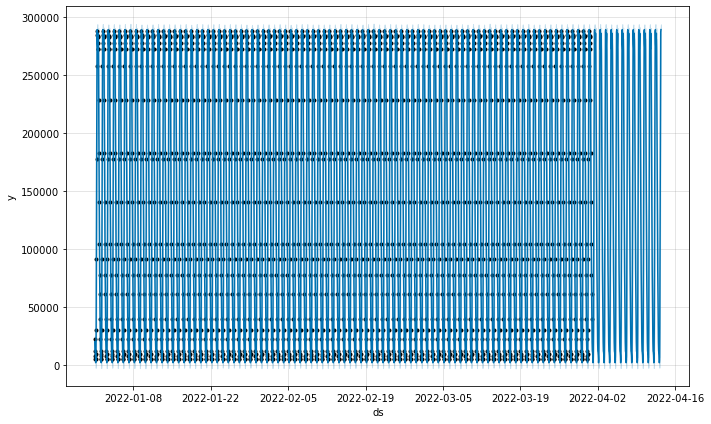

In [10]:
m = Prophet(daily_seasonality=True, changepoint_prior_scale=0.01).fit(aggr_df)
future = future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

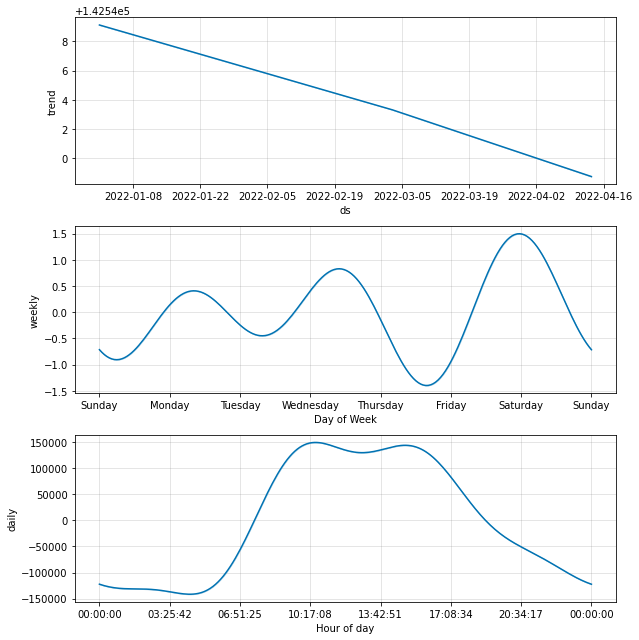

In [11]:
fig = m.plot_components(fcst)

In [12]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01 00:00:00,142549.108980,15629.894402,24926.285754,142549.108980,142549.108980,-122374.821516,-122374.821516,-122374.821516,-122376.317986,-122376.317986,-122376.317986,1.496470,1.496470,1.496470,0.0,0.0,0.0,20174.287464
1,2022-01-01 01:00:00,142549.105014,7500.228895,16856.593019,142549.105014,142549.105014,-130387.116088,-130387.116088,-130387.116088,-130388.596352,-130388.596352,-130388.596352,1.480263,1.480263,1.480263,0.0,0.0,0.0,12161.988926
2,2022-01-01 02:00:00,142549.101048,6667.649568,15480.248171,142549.101048,142549.101048,-131517.369776,-131517.369776,-131517.369776,-131518.820246,-131518.820246,-131518.820246,1.450471,1.450471,1.450471,0.0,0.0,0.0,11031.731273
3,2022-01-01 03:00:00,142549.097083,3923.108361,12667.688802,142549.097083,142549.097083,-134269.941719,-134269.941719,-134269.941719,-134271.349263,-134271.349263,-134271.349263,1.407544,1.407544,1.407544,0.0,0.0,0.0,8279.155363
4,2022-01-01 04:00:00,142549.093117,-2277.411542,6731.453804,142549.093117,142549.093117,-140464.949266,-140464.949266,-140464.949266,-140466.301340,-140466.301340,-140466.301340,1.352074,1.352074,1.352074,0.0,0.0,0.0,2084.143850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,2022-04-13 07:00:00,142538.775943,92399.807833,101371.290033,142538.762319,142538.790455,-45737.450901,-45737.450901,-45737.450901,-45738.239990,-45738.239990,-45738.239990,0.789089,0.789089,0.789089,0.0,0.0,0.0,96801.325042
2456,2022-04-13 08:00:00,142538.771362,174900.375422,183854.331081,142538.757651,142538.786001,36510.557438,36510.557438,36510.557438,36509.744658,36509.744658,36509.744658,0.812780,0.812780,0.812780,0.0,0.0,0.0,179049.328800
2457,2022-04-13 09:00:00,142538.766781,245885.964344,254719.697133,142538.752968,142538.781496,107937.036797,107937.036797,107937.036797,107936.210141,107936.210141,107936.210141,0.826657,0.826657,0.826657,0.0,0.0,0.0,250475.803578
2458,2022-04-13 10:00:00,142538.762200,282901.223886,291782.408780,142538.748293,142538.776988,144908.045798,144908.045798,144908.045798,144907.215532,144907.215532,144907.215532,0.830265,0.830265,0.830265,0.0,0.0,0.0,287446.807997


In [13]:
fcst = fcst[(fcst['ds'] > "2022-01-01") & (fcst['ds'] < "2022-01-02")]

In [14]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2022-01-01 01:00:00,142549.105014,7500.228895,16856.593019,142549.105014,142549.105014,-130387.116088,-130387.116088,-130387.116088,-130388.596352,-130388.596352,-130388.596352,1.480263,1.480263,1.480263,0.0,0.0,0.0,12161.988926
2,2022-01-01 02:00:00,142549.101048,6667.649568,15480.248171,142549.101048,142549.101048,-131517.369776,-131517.369776,-131517.369776,-131518.820246,-131518.820246,-131518.820246,1.450471,1.450471,1.450471,0.0,0.0,0.0,11031.731273
3,2022-01-01 03:00:00,142549.097083,3923.108361,12667.688802,142549.097083,142549.097083,-134269.941719,-134269.941719,-134269.941719,-134271.349263,-134271.349263,-134271.349263,1.407544,1.407544,1.407544,0.0,0.0,0.0,8279.155363
4,2022-01-01 04:00:00,142549.093117,-2277.411542,6731.453804,142549.093117,142549.093117,-140464.949266,-140464.949266,-140464.949266,-140466.301340,-140466.301340,-140466.301340,1.352074,1.352074,1.352074,0.0,0.0,0.0,2084.143850
5,2022-01-01 05:00:00,142549.089151,-264.440906,9030.532404,142549.089151,142549.089151,-138114.563963,-138114.563963,-138114.563963,-138115.848750,-138115.848750,-138115.848750,1.284787,1.284787,1.284787,0.0,0.0,0.0,4434.525188
6,2022-01-01 06:00:00,142549.085185,28564.726997,38030.449345,142549.085185,142549.085185,-108937.830387,-108937.830387,-108937.830387,-108939.036918,-108939.036918,-108939.036918,1.206531,1.206531,1.206531,0.0,0.0,0.0,33611.254798
7,2022-01-01 07:00:00,142549.081219,92068.242397,101306.443588,142549.081219,142549.081219,-45737.121721,-45737.121721,-45737.121721,-45738.239991,-45738.239991,-45738.239991,1.118270,1.118270,1.118270,0.0,0.0,0.0,96811.959499
8,2022-01-01 08:00:00,142549.077254,174382.600961,183628.697000,142549.077254,142549.077254,36510.765725,36510.765725,36510.765725,36509.744658,36509.744658,36509.744658,1.021068,1.021068,1.021068,0.0,0.0,0.0,179059.842979
9,2022-01-01 09:00:00,142549.073288,246087.851643,255148.132697,142549.073288,142549.073288,107937.126220,107937.126220,107937.126220,107936.210144,107936.210144,107936.210144,0.916077,0.916077,0.916077,0.0,0.0,0.0,250486.199508
10,2022-01-01 10:00:00,142549.069322,282558.273348,292063.157058,142549.069322,142549.069322,144908.020056,144908.020056,144908.020056,144907.215532,144907.215532,144907.215532,0.804524,0.804524,0.804524,0.0,0.0,0.0,287457.089378


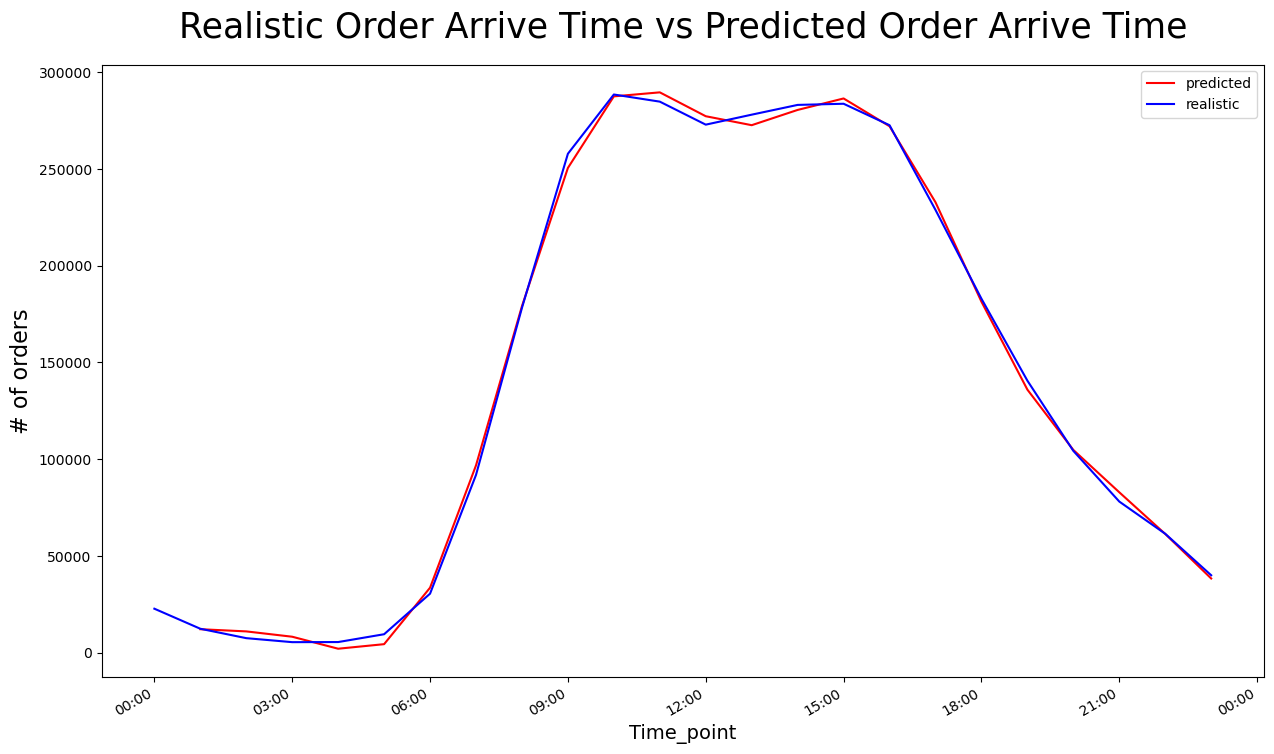

In [18]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(15,9), dpi=100)
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#plt.xticks(pd.date_range(fcst[''],table.index[-1],freq='H'), rotation=45)
ax.plot(fcst['ds'],fcst['yhat'],color='r', label='predicted')
ax.plot(aggr_df2['ds'],aggr_df2['y'],color='b', label='realistic')

plt.xlabel('Time_point', fontsize=14)   
plt.ylabel("# of orders", fontsize=16)
plt.title("Realistic Order Arrive Time vs Predicted Order Arrive Time", fontsize=25, color='black', pad=20)
plt.gcf().autofmt_xdate()

ax.legend()      

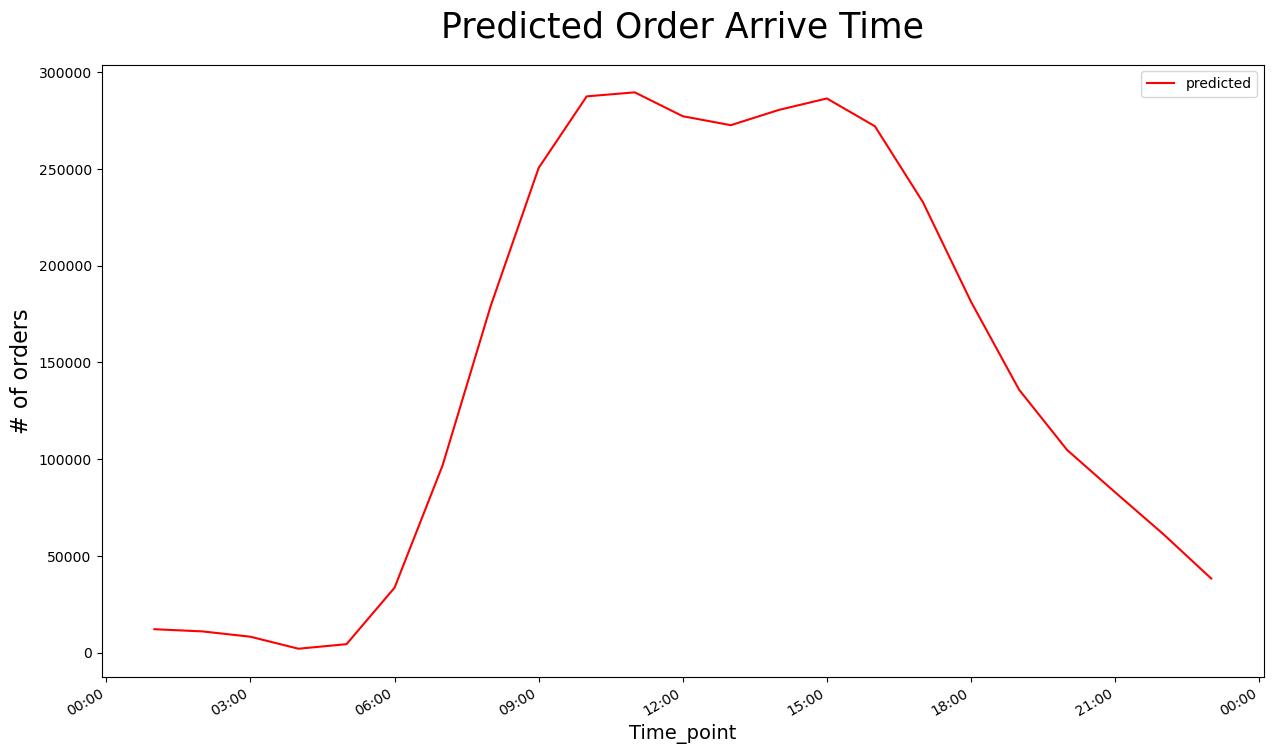

In [19]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(15,9), dpi=100)
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#plt.xticks(pd.date_range(fcst[''],table.index[-1],freq='H'), rotation=45)
ax.plot(fcst['ds'],fcst['yhat'],color='r', label='predicted')

plt.xlabel('Time_point', fontsize=14)   
plt.ylabel("# of orders", fontsize=16)
plt.title("Predicted Order Arrive Time", fontsize=25, color='black', pad=20)
plt.gcf().autofmt_xdate()

ax.legend()      